# Опис домашнього завдання

Сьогодні ти, маючи вхідний набір даних, опрацюєш його, розв’яжеш задачу прогнозування ціни оренди нерухомості та опишеш свої дії у презентації.

Як розв’язок, так і презентація матимуть 3 основні частини:

* Аналіз та підготовка даних.
* Моделювання.
* Аналіз результатів.

## Етап 1. Отримати дані та перетворити у **Data Frame**

In [17]:
import pandas as pd

df = pd.read_csv("House_Rent_Dataset.csv")

df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


## Етап 2. Аналіз та підготовка даних

Проаналізуй діапазони значень, їх середні та дисперсію, розподіли, кореляції, наявність пропущених значень, типи ознак.

In [18]:
df.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


Виведемо графік розподілу по стовпчику *Rent*. Але спершу створимо функцію, котра виведе розподіли

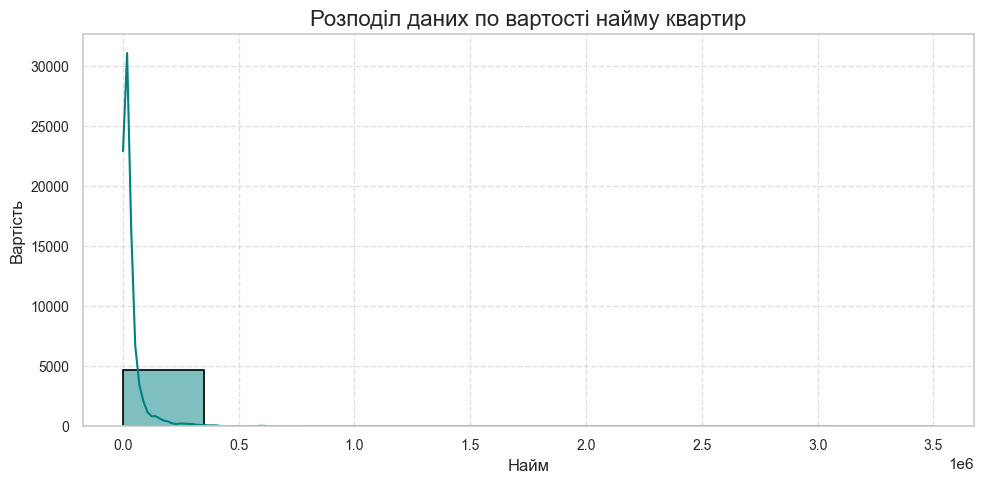

In [19]:
from home_work_10 import draw_dispersion_num

draw_dispersion_num(df, "Rent", "Розподіл даних по вартості найму квартир", "Найм", "Вартість")

З графіку бачимо, що розподіл даних не є *нормальним* але, швидше, *експоненційним*. Це видно із того, що дані сконцентровані на нулі і мають правосторонній хвіст. Як побачимо нижче, *моделі лінійної регресії* даватимуть гірший результат, аніж модель *дерева рішень*.

Перевір на наявність пропущених значень. За наявності заповни їх або видали рядки з пропусками.

In [20]:
print(df.isna().any().any())
df = df.dropna(axis=0)

False


З виводу бачимо, що пропусків нема.

## Перетворення даних

Як показує практика, робота моделей *прогнозування* та *класифікації даних* погано працюють із стрічковими даними. Тому для швидшої та кращої роботи моделі слід певним чином перетворити колонки, що містять текстові дані але є важливими для прогнозування. Отже ми:
- В категоріальних колонках (таких, як *поверх* чи *розташування*), які не можна виразити у вигляді **булевих значень** текстові дані перекодуємо числовим чином
- В категоріальних колонках, котрі ми можемо виразити **булево**, ми розбиваємо по повторюваних значеннях, як колонках, де значення може бути лише *істиною* чи *хибою*

Це дозволить моделі витрачати менше ресурсів на категоризацію, а також уникати непередбачуваних помиок у сирих текстових даних.

In [21]:
df = pd.get_dummies(df, columns=['Area Type'])
df = pd.get_dummies(df, columns=['Tenant Preferred'])
df = pd.get_dummies(df, columns=['Furnishing Status'])
df['Floor'] = df['Floor'].astype('category').cat.codes
df['Area Locality'] = df['Area Locality'].astype('category').cat.codes
df['City'] = df['City'].astype('category').cat.codes
df = df.drop('Posted On', axis=1)
df = df.drop('Point of Contact', axis=1)
df.head()

,BHK,Rent,Size,Floor,Area Locality,City,Bathroom,Area Type_Built Area,Area Type_Carpet Area,Area Type_Super Area,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished
0,2,10000,1100,455,221,4,2,False,False,True,False,True,False,False,False,True
1,2,20000,800,14,1527,4,1,False,False,True,False,True,False,False,True,False
2,2,17000,1000,14,1760,4,1,False,False,True,False,True,False,False,True,False
3,2,10000,800,10,526,4,1,False,False,True,False,True,False,False,False,True
4,2,7500,850,10,1890,4,1,False,True,False,True,False,False,False,False,True


## Виділити дані для аналізу та змінну прогнозування

Позначимо:
- **X** - містить дані, на яких вчимося та використовуємо для прогнозування. Це всі дані, окрім *Rent*, котре ми і хочемо спрогнозувати
- **y** - це саме колонка *Rent*, котру хочемо навчитися прогнозувати. Але вона міститиме і реальні значення для тренування та порівняння

In [22]:
y = df.Rent
X = df.drop(['Rent'], axis=1)

X.head()

,BHK,Size,Floor,Area Locality,City,Bathroom,Area Type_Built Area,Area Type_Carpet Area,Area Type_Super Area,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished
0,2,1100,455,221,4,2,False,False,True,False,True,False,False,False,True
1,2,800,14,1527,4,1,False,False,True,False,True,False,False,True,False
2,2,1000,14,1760,4,1,False,False,True,False,True,False,False,True,False
3,2,800,10,526,4,1,False,False,True,False,True,False,False,False,True
4,2,850,10,1890,4,1,False,True,False,True,False,False,False,False,True


## Розділяємо дані на тренувальні та тестові

*Тренувальні дані* потрібні нам для навчання моделі, тоді, як *тестові* будуть використовуватись для перевірки правильності **прогнозування** моделі.
Позначимо:
- **X_train, y_train** - для тренувальних *X* i *y*
- **X_test, y_test** - для тестових *X* i *Y*

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from home_work_10 import *

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Етап №3. Запуск та аналіз моделей

Будемо будувати 2 основні типа моделей:
- Модель на основі дерева рішень
- Моделі на основі лінійної регресії

Оцінювати моделі будемо наступними метриками:
- *R² — коефіцієнт детермінації* - це метрика, яка показує наскільки добре модель пояснює варіацію цільової змінної
- *MAE — середня абсолютна помилка* - це метрика якості регресійної моделі, яка показує середнє значення відхилення передбачень від справжніх значень у абсолютному вираженні.
- *MSE — середньоквадратична помилка* - це метрика, яка показує середній квадрат різниці між справжніми та передбаченими значеннями. Вона оцінює, наскільки далеко передбачення моделі в середньому відхиляються від реальних даних, штрафуючи великі помилки сильніше.

Аналізуватимемо якість моделей також і через візуалізації:
- Розподіл даних між тестовими та передбаченими даними. Наочно покаже розкид чи різницю між передбаченими та тестовими даними. Ідеально буде, якщо з обох сторін все буде симетрично
- Розкид по рештках. Чим далі від нуля, тим більший коефіцієнт помилки.

## Модель на основі Дерева рішень

**DecisionTreeRegressor** — це модель _регресії_, яка використовує д*ерево рішень* для прогнозування числового значення. Вона розбиває простір ознак на підмножини, у яких середнє значення цільової змінної є найбільш “точним” передбаченням.

In [24]:
from sklearn.tree import DecisionTreeRegressor


# Визначаємо модель
decision_tree_model = DecisionTreeRegressor(random_state=1)

# Навчаємо модель на тренувальних даних
decision_tree_model.fit(X_train, y_train)
y_pred = decision_tree_model.predict(X_test)

# R² — коефіцієнт детермінації
r2 = r2_score(y_test, y_pred)

# MAE — середня абсолютна помилка
mae = mean_absolute_error(y_test, y_pred)

# MSE — середньоквадратична помилка
mse = mean_squared_error(y_test, y_pred)

print(f'R²: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')


R²: 0.24
MAE: 17573.04
MSE: 7709492044.74


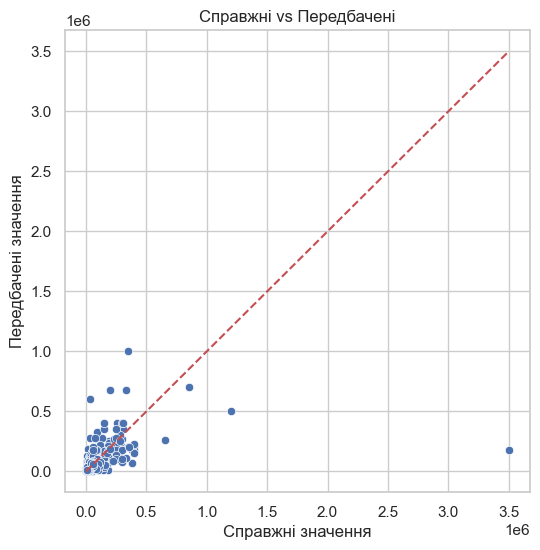

In [25]:
draw_comparable_scatter(y_test, y_pred)

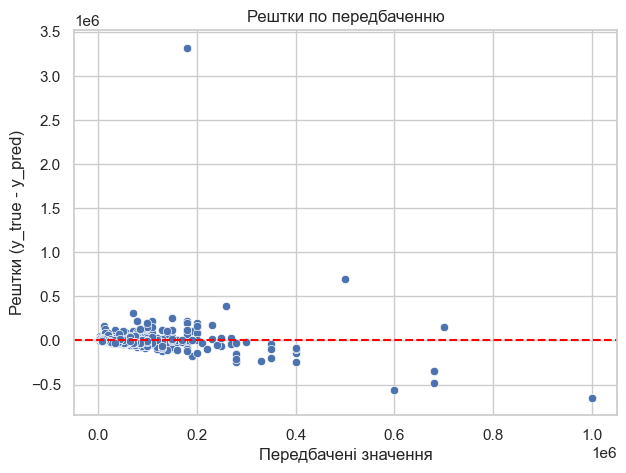

In [26]:
draw_error_plot(y_test, y_pred)

## Модель на основі Лінійної регресії

**LinearRegression** — це базова модель _лінійної регресії_, яка шукає лінійну залежність між вхідними ознаками `(X)` і цільовою змінною `(y)`. Мета — підібрати _коефіцієнти_, які мінімізують різницю між _реальними_ та _передбаченими_ значеннями.

In [27]:
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()

# Піджени модель!
linear_regression_model.fit(X_train, y_train)
y_pred = linear_regression_model.predict(X_test)

# R² — коефіцієнт детермінації
r2 = r2_score(y_test, y_pred)

# MAE — середня абсолютна помилка
mae = mean_absolute_error(y_test, y_pred)

# MSE — середньоквадратична помилка
mse = mean_squared_error(y_test, y_pred)

print(f'R²: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

R²: 0.18
MAE: 25755.29
MSE: 8318538192.78


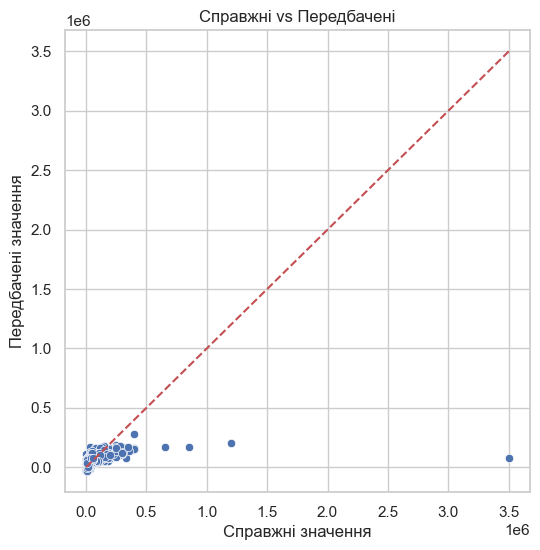

In [28]:
draw_comparable_scatter(y_test, y_pred)

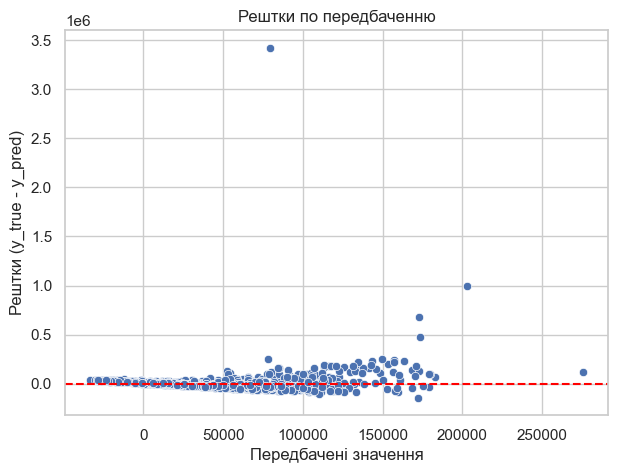

In [29]:
draw_error_plot(y_test, y_pred)

## Модель на основі конвеєру, що включає лінійну регресію з поліномінальним додатком

**Конвеєр (Pipeline)** — це зручний інструмент у _sklearn_, який дозволяє послідовно об’єднати кілька етапів обробки даних у єдиний об’єкт. Це корисно для побудови повного ланцюга машинного навчання: від попередньої обробки до навчання моделі.

Ми використовуємо конвеєри для:

-	Автоматизувати послідовність кроків (наприклад: нормалізація → поліном → модель).
-	Гарантувати коректність: трансформації навчаються тільки на X_train, а потім застосовуються до X_test.
-	Спрощує код та покращує читабельність.

У цьому конвеєрі ми пропускаємо наш тренувальний датасет через порліноміальну обробку і передає результат лінійній регресії.

**PolynomialFeatures** — це інструмент у scikit-learn, який розширює набір ознак, створюючи поліноміальні комбінації початкових ознак до заданого _степеня (degree)_.

Поліноміальні ознаки дозволяють лінійній моделі вловлювати нелінійні зв’язки між змінними. Наприклад, замість просто:
$y = \beta_0 + \beta_1 x$
можемо моделювати:
$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \dots$

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

polinomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# Піджени модель!
polinomial_model.fit(X_train, y_train)  # Змінено y_test на y_train
y_pred = polinomial_model.predict(X_test)

# R² — коефіцієнт детермінації
r2 = r2_score(y_test, y_pred)

# MAE — середня абсолютна помилка
mae = mean_absolute_error(y_test, y_pred)

# MSE — середньоквадратична помилка
mse = mean_squared_error(y_test, y_pred)

print(f'R²: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

R²: 0.26
MAE: 20179.88
MSE: 7538268204.24


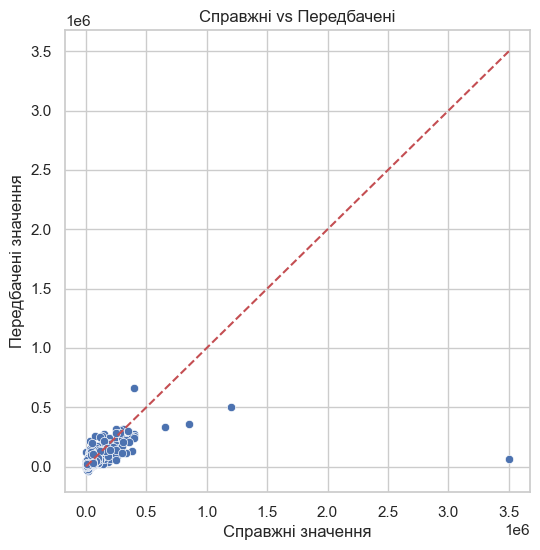

In [31]:
draw_comparable_scatter(y_test, y_pred)

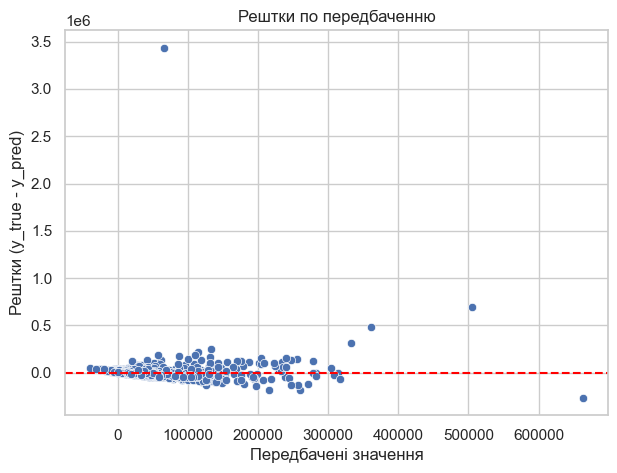

In [32]:
draw_error_plot(y_test, y_pred)

# Висновок

З аналізу результатів кожної моделі можемо так розподілити моделі по коректності за `R²`:

1. Конвеєр *Поліноміальне перетворення* + *Лінійна регресія* (0.26)
2. Модель на основі *Дерева рішень* (0.24)
3. Модель на основі Лінійної регресії (0.18)

За `MAE — середня абсолютна помилка`:
1. Модель на основі *Дерево рішень* (17573.04)
2. Конвеєр *Поліноміальне перетворення* + *Лінійна регресія* (20179.88)
3. Модель на основі Лінійної регресії (25755.29)

За `MSE — середньоквадратична помилка`:
1. Конвеєр *Поліноміальне перетворення* + *Лінійна регресія* (07538268204.24)
2. Модель на основі *Дерева рішень* (7538268204.24)
3. Модель на основі Лінійної регресії (8318538192.78)

Як бачимо, найкращими будуть **Дерево рішень** та конвеєр **Поліноміальне перетворення + Лінійна регресія**. Проста **Лінійна регресія** за всіма показниками є гіршою, оскільки самі дані джерела не є лінійними і навіть не розподіляються **нормальним розподілом**. Просто пропустити дані через поліноміальний фільтр значно покращує ьодель на основі лінійної регресії. Це показує, наскільки використання конвеєрів підвищує гнучкість та настроюваність результуючої моделі.

Як бачимо по графікам розкиду помилок, всі иоделі найбільше помиляються на відрізку *5000 - 30000* колонки *Rent*. Бачимо також, що із збільшенням значень *Rent* точність прогнозування усіх моделей падає.

В загальному, всі моделі виявились неефективними, адже найвищий `R²` складає всього лиш **28%**. Дані не були оброблені на викиди та аномалії та, можливо, параметри моделей потребували уважнішого налаштування.